In [1]:
!nvidia-smi

Fri May  7 05:42:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Notes

Days back, I've shared this [infernece kernel](https://www.kaggle.com/kneroma/clean-fast-simple-bird-identifier-inference). But its weights are static as you can't retrain the model. In this work, I'm gonna release the training notebook which is almost my internal training pipeline. I removed some experimentation ideas to make things clearer and straightforward. Don't mind adding new ideas at your side as well.

To make the training faster, we cached the training set into RAM. The whole training records are already [converted into handy  melspecs images](https://www.kaggle.com/kneroma/kkiller-birdclef-2021). These images are from 7 seconds extracts (training on 7 seconds seems to be more effective than 5 seconds). Longer records are truncated into random 7x10 seconds.

**If one is interessted in to the whole records' melspecs** (no truncation):
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part1
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part2
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part3
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part4

### Tips & suggestions
* You can choose a wide set of models from the **get_model** interface : ["resnest*", "resnet*", "resnext*", "efficientnet*" ...]
* You can change the learning rate scheduler: OneCycle ? ReduceOnPlateau ?
* Adds secondary labels
* Use train & test metadata (dates, positions (longitude, latitude), ...)
* Add melspecs augmentation

**For Colab training, you just have to uncomment the first cells**

# Versions

* **v1** : initial version
* **v3** : enable training on whole (no truncation) record melspecs

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ! pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
# ! mkdir ~/.kaggle
# ! cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# %%time

# import os
# if not os.path.exists("/content/datasets/audio_images"):
#   !mkdir datasets
#   !kaggle datasets download -d kneroma/kkiller-birdclef-2021
#   !unzip /content//kkiller-birdclef-2021.zip -d datasets

In [3]:
!pip install -q pysndfx SoundFile audiomentations pretrainedmodels efficientnet_pytorch resnest

In [4]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

from resnest.torch import resnest50

from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval


from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

In [5]:
from efficientnet_pytorch import EfficientNet
import pretrainedmodels
import resnest.torch as resnest_torch

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [7]:
NUM_CLASSES = 397
SR = 32_000
DURATION = 7

MAX_READ_SAMPLES = 5 # Each record will have 10 melspecs at most, you can increase this on Colab with High Memory Enabled

# # For colab
# DATA_ROOT = Path("/content/datasets/")
# TRAIN_IMAGES_ROOT = Path("/content/datasets/audio_images")
# TRAIN_LABELS_FILE = Path("/content/datasets/rich_train_metadata.csv")
# MODEL_ROOT = Path("/content/drive/My Drive/Kaggle/BirdClef2021/models")

DATA_ROOT = Path("../input/birdclef-2021")
# TRAIN_IMAGES_ROOT = Path("../input/kkiller-birdclef-2021/audio_images")
# TRAIN_LABELS_FILE = Path("../input/kkiller-birdclef-2021/rich_train_metadata.csv")

MEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/rich_train_metadata.csv"))
TRAIN_LABEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/LABEL_IDS.json"))

MODEL_ROOT = Path(".")

In [10]:
MEL_PATHS

[PosixPath('../input/kkiller-birdclef-mels-computer-d7-part1/rich_train_metadata.csv'),
 PosixPath('../input/kkiller-birdclef-mels-computer-d7-part2/rich_train_metadata.csv'),
 PosixPath('../input/kkiller-birdclef-mels-computer-d7-part3/rich_train_metadata.csv'),
 PosixPath('../input/kkiller-birdclef-mels-computer-d7-part4/rich_train_metadata.csv')]

In [17]:
TRAIN_LABEL_PATHS

[PosixPath('../input/kkiller-birdclef-mels-computer-d7-part1/LABEL_IDS.json'),
 PosixPath('../input/kkiller-birdclef-mels-computer-d7-part2/LABEL_IDS.json'),
 PosixPath('../input/kkiller-birdclef-mels-computer-d7-part3/LABEL_IDS.json'),
 PosixPath('../input/kkiller-birdclef-mels-computer-d7-part4/LABEL_IDS.json')]

In [11]:
TRAIN_BATCH_SIZE = 100
TRAIN_NUM_WORKERS = 2

VAL_BATCH_SIZE = 128
VAL_NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


In [12]:
def get_df(mel_paths=MEL_PATHS, train_label_paths=TRAIN_LABEL_PATHS):
  df = None
  LABEL_IDS = {}
    
  for file_path in mel_paths:
    temp = pd.read_csv(str(file_path), index_col=0)
    temp["impath"] = temp.apply(lambda row: file_path.parent/"audio_images/{}/{}.npy".format(row.primary_label, row.filename), axis=1) 
    df = temp if df is None else df.append(temp)
    
  df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)
  # Recall that we have done this: from ast import literal_eval

  for file_path in train_label_paths:
    with open(str(file_path)) as f:
      LABEL_IDS.update(json.load(f))

  return LABEL_IDS, df

In [13]:
# df = pd.read_csv(TRAIN_LABELS_FILE, nrows=None)
# df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)
# LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}

# print(df.shape)
# df.head()

In [14]:
LABEL_IDS, df = get_df()

print(df.shape)
df.head()

(62874, 21)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,...,rating,time,url,label_id,filepath,frames,sr,duration,fold,impath
0,acafly,[amegfi],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,...,2.5,09:30,https://www.xeno-canto.org/109605,0,../input/birdclef-2021/train_short_audio/acafl...,2037586,32000,63.674563,0,../input/kkiller-birdclef-mels-computer-d7-par...
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,...,3.0,?,https://www.xeno-canto.org/11209,0,../input/birdclef-2021/train_short_audio/acafl...,532933,32000,16.654156,1,../input/kkiller-birdclef-mels-computer-d7-par...
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,...,3.0,15:20,https://www.xeno-canto.org/127032,0,../input/birdclef-2021/train_short_audio/acafl...,1508450,32000,47.139063,3,../input/kkiller-birdclef-mels-computer-d7-par...
3,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,...,3.5,07:50,https://www.xeno-canto.org/129974,0,../input/birdclef-2021/train_short_audio/acafl...,450177,32000,14.068031,4,../input/kkiller-birdclef-mels-computer-d7-par...
4,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,...,3.5,07:50,https://www.xeno-canto.org/129981,0,../input/birdclef-2021/train_short_audio/acafl...,1301142,32000,40.660688,2,../input/kkiller-birdclef-mels-computer-d7-par...


In [18]:
!diff ../input/kkiller-birdclef-mels-computer-d7-part1/LABEL_IDS.json ../input/kkiller-birdclef-mels-computer-d7-part2/LABEL_IDS.json 

In [19]:
!diff ../input/kkiller-birdclef-mels-computer-d7-part2/LABEL_IDS.json ../input/kkiller-birdclef-mels-computer-d7-part3/LABEL_IDS.json 

In [20]:
!diff ../input/kkiller-birdclef-mels-computer-d7-part3/LABEL_IDS.json ../input/kkiller-birdclef-mels-computer-d7-part4/LABEL_IDS.json 

In [21]:
df["primary_label"].value_counts()

rewbla     500
spotow     500
cubthr     500
comrav     500
norcar     500
          ... 
whcpar      12
wegspa1     10
runwre1      9
crfpar       8
stvhum2      8
Name: primary_label, Length: 397, dtype: int64

In [22]:
df["label_id"].min(), df["label_id"].max()

(0, 396)

In [23]:
def get_model(name, num_classes=NUM_CLASSES):
    """
    Loads a pretrained model. 
    Supports ResNest, ResNext-wsl, EfficientNet, ResNext and ResNet.

    Arguments:
        name {str} -- Name of the model to load

    Keyword Arguments:
        num_classes {int} -- Number of classes to use (default: {1})

    Returns:
        torch model -- Pretrained model
    """
    if "resnest" in name:
        model = getattr(resnest_torch, name)(pretrained=True)
    elif "wsl" in name:
        model = torch.hub.load("facebookresearch/WSL-Images", name)
    elif name.startswith("resnext") or  name.startswith("resnet"):
        model = torch.hub.load("pytorch/vision:v0.6.0", name, pretrained=True)
    elif name.startswith("tf_efficientnet_b"):
        model = getattr(timm.models.efficientnet, name)(pretrained=True)
    elif "efficientnet-b" in name:
        model = EfficientNet.from_pretrained(name)
    else:
        model = pretrainedmodels.__dict__[name](pretrained='imagenet')
        # Recall: import pretrainedmodels

    if hasattr(model, "fc"):
        nb_ft = model.fc.in_features
        model.fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "_fc"):
        nb_ft = model._fc.in_features
        model._fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "classifier"):
        nb_ft = model.classifier.in_features
        model.classifier = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "last_linear"):
        nb_ft = model.last_linear.in_features
        model.last_linear = nn.Linear(nb_ft, num_classes)

    return model

In [31]:
def load_data(df):
    def load_row(row):
        # impath = TRAIN_IMAGES_ROOT/f"{row.primary_label}/{row.filename}.npy"
        return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES]
    pool = joblib.Parallel(4)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    return res

In [32]:
# We cache the train set to reduce training time

audio_image_store = load_data(df)
len(audio_image_store)

  0%|          | 0/62874 [00:00<?, ?it/s]

62874

In [33]:
type(audio_image_store)

dict

In [36]:
list(audio_image_store.keys())[:10]

['XC109605.ogg',
 'XC11209.ogg',
 'XC127032.ogg',
 'XC129974.ogg',
 'XC129981.ogg',
 'XC130056.ogg',
 'XC130133.ogg',
 'XC130140.ogg',
 'XC130750.ogg',
 'XC131193.ogg']

In [38]:
i = 0
for k, v in audio_image_store.items():
    print(f"k = {k}")
    print(f"type(v) = {type(v)}")
    #print(f"v = {v}")
    i += 1
    if i > 3:
        break

k = XC109605.ogg
type(v) = <class 'numpy.ndarray'>
k = XC11209.ogg
type(v) = <class 'numpy.ndarray'>
k = XC127032.ogg
type(v) = <class 'numpy.ndarray'>
k = XC129974.ogg
type(v) = <class 'numpy.ndarray'>


In [41]:
first_image = next(iter(audio_image_store.values()))
first_image.shape  # note that it has 5 channels

(5, 128, 281)

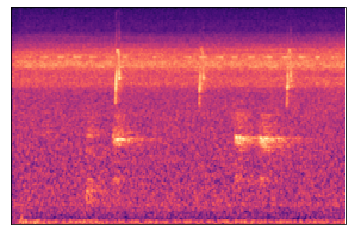

In [43]:
lbd.specshow(first_image[0]);  # let's visualize the first channel

In [44]:
pd.Series([len(x) for x in audio_image_store.values()]).value_counts()  # a statistic on number of channels of the images

5    39090
1     7271
2     5886
3     5625
4     5002
dtype: int64

In [45]:
pd.Series([f"({x.shape[1]}, {x.shape[2]})" for x in audio_image_store.values()]).value_counts()  # a statistic on shapes of the images

(128, 281)    62874
dtype: int64

In [46]:
class BirdClefDataset(Dataset):

    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=NUM_CLASSES, duration=DURATION):
        
        self.audio_image_store = audio_image_store
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
    
    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        image = self.audio_image_store[row.filename]

        image = image[np.random.choice(len(image))]  # randomly choose one of the original image's channels
        image = self.normalize(image)  # make the final image into 3 channels
        
        
        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 # Label smoothing
        t[row.label_id] = 0.995
        
        return image, t

**(?)** Label smoothing?  `1 == 0.0025*(NUM_CLASSES-1) + 0.995`?<br>
**(R)** Maybe because we are not doing single-label classification (i.e. not `softmax`), the labels not summing up to `1` may not matter much.

In [49]:
0.0025*(NUM_CLASSES-1) + 0.995

1.9849999999999999

In [47]:
ds = BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=DURATION, is_train=True)
len(df)

62874

In [48]:
len(audio_image_store)

62874

In [50]:
x, y = ds[np.random.choice(len(ds))]
# x, y = ds[0]
x.shape, y.shape, np.where(y >= 0.5)

((3, 128, 281), (397,), (array([353]),))

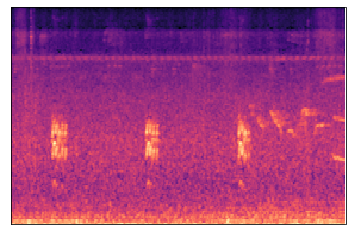

In [52]:
lbd.specshow(x[0]);

In [53]:
y[:5]

array([0.0025, 0.0025, 0.0025, 0.0025, 0.0025], dtype=float32)

# Training the model

In [54]:
def one_step(xb, yb, net, criterion, optimizer, scheduler=None):
  xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        
  optimizer.zero_grad()
  o = net(xb)
  loss = criterion(o, yb)
  loss.backward()
  optimizer.step()
  
  with torch.no_grad():
      l = loss.item()

      o = o.sigmoid()
      yb = (yb > 0.5 )*1.0
      lrap = label_ranking_average_precision_score(yb.cpu().numpy(), o.cpu().numpy())

      o = (o > 0.5)*1.0

      prec = (o*yb).sum()/(1e-6 + o.sum())
      rec = (o*yb).sum()/(1e-6 + yb.sum())
      f1 = 2*prec*rec/(1e-6+prec+rec)

  if  scheduler is not None:
    scheduler.step()

  return l, lrap, f1.item(), rec.item(), prec.item()

In [55]:
@torch.no_grad()
def evaluate(net, criterion, val_laoder):
    net.eval()

    os, y = [], []
    val_laoder = tqdm(val_laoder, leave = False, total=len(val_laoder))

    for icount, (xb, yb) in  enumerate(val_laoder):

        y.append(yb.to(DEVICE))

        xb = xb.to(DEVICE)
        o = net(xb)

        os.append(o)

    y = torch.cat(y)
    o = torch.cat(os)

    l = criterion(o, y).item()
    
    o = o.sigmoid()
    y = (y > 0.5)*1.0

    lrap = label_ranking_average_precision_score(y.cpu().numpy(), o.cpu().numpy())

    o = (o > 0.5)*1.0

    prec = ((o*y).sum()/(1e-6 + o.sum())).item()
    rec = ((o*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)

    return l, lrap, f1, rec, prec, 
    

In [56]:
def one_epoch(net, criterion, optimizer, scheduler, train_laoder, val_laoder):
  net.train()
  l, lrap, prec, rec, f1, icount = 0.,0.,0.,0., 0., 0
  train_laoder = tqdm(train_laoder, leave = False)
  epoch_bar = train_laoder
  
  for (xb, yb) in  epoch_bar:
      # epoch_bar.set_description("----|----|----|----|---->")
      _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
      l += _l
      lrap += _lrap
      f1 += _f1
      rec += _rec
      prec += _prec

      icount += 1
        
      if hasattr(epoch_bar, "set_postfix") and not icount%10:
          epoch_bar.set_postfix(
            loss="{:.6f}".format(l/icount),
            lrap="{:.3f}".format(lrap/icount),
            prec="{:.3f}".format(prec/icount),
            rec="{:.3f}".format(rec/icount),
            f1="{:.3f}".format(f1/icount),
          )
  
  scheduler.step()

  l /= icount
  lrap /= icount
  f1 /= icount
  rec /= icount
  prec /= icount
  
  l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_laoder)
  
  return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val)

In [57]:
class AutoSave:
  def __init__(self, top_k=2, metric="f1", mode="min", root=None, name="ckpt"):
    self.top_k = top_k
    self.logs = []
    self.metric = metric
    self.mode = mode
    self.root = Path(root or MODEL_ROOT)
    assert self.root.exists()
    self.name = name

    self.top_models = []
    self.top_metrics = []

  def log(self, model, metrics):
    metric = metrics[self.metric]
    rank = self.rank(metric)

    self.top_metrics.insert(rank+1, metric)
    if len(self.top_metrics) > self.top_k:
      self.top_metrics.pop(0)

    self.logs.append(metrics)
    self.save(model, metric, rank, metrics["epoch"])


  def save(self, model, metric, rank, epoch):
    t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
    name = re.sub(r"[^\w_-]", "", name) + ".pth"
    path = self.root.joinpath(name)

    old_model = None
    self.top_models.insert(rank+1, name)
    if len(self.top_models) > self.top_k:
      old_model = self.root.joinpath(self.top_models[0])
      self.top_models.pop(0)      

    torch.save(model.state_dict(), path.as_posix())

    if old_model is not None:
      old_model.unlink()

    self.to_json()


  def rank(self, val):
    r = -1
    for top_val in self.top_metrics:
      if val <= top_val:
        return r
      r += 1

    return r
  
  def to_json(self):
    # t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_logs".format(self.name)
    name = re.sub(r"[^\w_-]", "", name) + ".json"
    path = self.root.joinpath(name)

    with path.open("w") as f:
      json.dump(self.logs, f, indent=2)


In [58]:
def one_fold(model_name, fold, train_set, val_set, epochs=20, save=True, save_root=None):

  save_root = Path(save_root) or MODEL_ROOT

  saver = AutoSave(root=save_root, name=f"birdclef_{model_name}_fold{fold}", metric="f1_val")

  net = get_model(model_name).to(DEVICE)

  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.Adam(net.parameters(), lr=8e-4)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)

  train_data = BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=DURATION, is_train=True)
  train_laoder = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=TRAIN_NUM_WORKERS, shuffle=True, pin_memory=True)

  val_data = BirdClefDataset(audio_image_store, meta=df.iloc[val_set].reset_index(drop=True),  sr=SR, duration=DURATION, is_train=False)
  val_laoder = DataLoader(val_data, batch_size=VAL_BATCH_SIZE, num_workers=VAL_NUM_WORKERS, shuffle=False)

  epochs_bar = tqdm(list(range(epochs)), leave=False)
  for epoch  in epochs_bar:
    epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
    net.train()

    (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val) = one_epoch(
        net=net,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_laoder=train_laoder,
        val_laoder=val_laoder,
      )

    epochs_bar.set_postfix(
    loss="({:.6f}, {:.6f})".format(l, l_val),
    prec="({:.3f}, {:.3f})".format(prec, prec_val),
    rec="({:.3f}, {:.3f})".format(rec, rec_val),
    f1="({:.3f}, {:.3f})".format(f1, f1_val),
    lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
    )

    print(
        "[{epoch:02d}] loss: {loss} lrap: {lrap} f1: {f1} rec: {rec} prec: {prec}".format(
            epoch=epoch,
            loss="({:.6f}, {:.6f})".format(l, l_val),
            prec="({:.3f}, {:.3f})".format(prec, prec_val),
            rec="({:.3f}, {:.3f})".format(rec, rec_val),
            f1="({:.3f}, {:.3f})".format(f1, f1_val),
            lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
        )
    )

    if save:
      metrics = {
          "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
          "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
          "epoch": epoch,
      }

      saver.log(net, metrics)

In [ ]:
df.fold.head()

In [59]:
def train(model_name, epochs=20, save=True, n_splits=5, seed=177, save_root=None, suffix="", folds=None):
  gc.collect()
  torch.cuda.empty_cache()

  save_root = save_root or MODEL_ROOT/f"{model_name}{suffix}"
  save_root.mkdir(exist_ok=True, parents=True)
  
  fold_bar = tqdm(df.reset_index().groupby("fold").index.apply(list).items(), total=df.fold.max()+1)
  
  for fold, val_set in fold_bar:
      if folds and not fold in folds:
        continue
      
      print(f"\n############################### [FOLD {fold}]")
      fold_bar.set_description(f"[FOLD {fold}]")
      train_set = np.setdiff1d(df.index, val_set)
        
      one_fold(model_name, fold=fold, train_set=train_set , val_set=val_set , epochs=epochs, save=save, save_root=save_root)
    
      gc.collect()
      torch.cuda.empty_cache()

In [60]:
MODEL_NAMES = [
      "resnest50",
] 

In [61]:
for model_name in MODEL_NAMES:
  print("\n\n###########################################", model_name.upper())
  try:
    train(model_name, epochs=2, suffix=f"_sr{SR}_d{DURATION}_v1_v1", folds=[0])
  except Exception as e:
    # print(f"Error {model_name} : \n{e}")
    raise ValueError() from  e



########################################### RESNEST50


  0%|          | 0/5 [00:00<?, ?it/s]


############################### [FOLD 0]


Downloading: "https://s3.us-west-1.wasabisys.com/resnest/torch/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[00] loss: (0.032492, 0.027001) lrap: (0.201, 0.426) f1: (0.046, 0.186) rec: (0.027, 0.106) prec: (0.372, 0.767)


  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[01] loss: (0.025088, 0.024601) lrap: (0.581, 0.613) f1: (0.373, 0.423) rec: (0.242, 0.283) prec: (0.862, 0.834)


In [64]:
ls resnest50_sr32000_d7_v1_v1/

birdclef_resnest50_fold0_epoch_00_f1_val_01857_20210507073557.pth
birdclef_resnest50_fold0_epoch_01_f1_val_04227_20210507074627.pth
birdclef_resnest50_fold0_logs.json
